# 06.1. Optimizacion_Modelo_Academico

---

## Objetivo
Optimizar el rendimiento estadístico del modelo **`95_Original`** sin considerar restricciones de negocio. Se realiza una búsqueda de hiperparámetros en dos etapas (aleatoria y de rejilla) para encontrar la mejor configuración que maximice el **AUC** en la clasificación binaria (2 clases) y el **F1-macro** en la de cuatro clases. Finalmente, se guarda el modelo campeón optimizado para AUC.



## Entradas (Inputs)

### Splits Finales (desde `data/splits/final/`)
- `X_train.parquet`
- `X_val.parquet`
- `X_test.parquet`
- `y_train.parquet`
- `y_val.parquet`
- `y_test.parquet`



## Salidas (Outputs)

### Modelos Finales (en `models/final/`)
- `modelo_riesgo_auc_v1.joblib`

---

## Resumen Ejecutivo
- **Objetivo:** Desarrollar y optimizar modelos de clasificación para predecir riesgo académico en dos formatos: binario (2 clases) y multicategorías (4 clases).  
- **Técnicas empleadas:**  
  - Pipeline con StandardScaler, SMOTE y RandomForestClassifier (class_weight=balanced).  
  - Búsqueda de hiperparámetros en dos etapas: RandomizedSearchCV (60 iteraciones) y GridSearchCV focalizado.  
  - Validación cruzada a 3 pliegues, optimizando AUC para binario y F1-macro para multicategorías.  
- **Resultados más relevantes:**  
  - **Modelo 2 clases:** AUC CV = 0.7667; AUC Test = 0.7752; precisión global ≈ 0.73; macro-F1 ≈ 0.70.  
  - **Modelo 4 clases:** F1-macro CV = 0.4839; F1-macro Test = 0.4735; exactitud ≈ 0.58; mejor desempeño en la clase 3 (F1=0.70).  
- **Insight clave:** La discriminación binaria es sólida, pero la segmentación en cuatro niveles presenta desafíos, especialmente en clases con menor soporte.
---

## 1. Importaciones y configuración del entorno

Agrupa y ordena todas las sentencias `import` en secciones de biblioteca estándar, terceros y locales según PEP8; además monta Google Drive y añade la ruta del proyecto al `sys.path`.


In [ ]:
import sys
import os
from pathlib import Path

# 1. Añadir la raíz del proyecto al path
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# MONTAR DRIVE, IMPORTAR LIBRERÍAS Y CARGAR CONFIGURACIÓN

# Google Colab

# Standard library
from pathlib import Path
import json
import warnings

# Data processing
import pandas as pd
import numpy as np
import joblib

# Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Optuna para optimización de hiperparámetros
import optuna

# Visualización
import matplotlib.pyplot as plt

# Configuración local
from config import EXP_SPLITS_DIR, EXP_ARTIFACTS_DIR, FINAL_SPLITS_DIR



# --- 3. Importar las rutas necesarias desde el archivo de configuración ---
# Este notebook usa los splits FINALES y guarda un modelo FINAL.
from config import FINAL_SPLITS_DIR, FINAL_MODELS_DIR

print("Entorno preparado y configuración de rutas cargada desde config.py.")

Mounted at /content/drive
✅ Módulo de configuración cargado y estructura de carpetas asegurada.
✅ Entorno preparado y configuración de rutas cargada desde config.py.


## 2. Carga y preparación de datos

Carga los conjuntos de entrenamiento, validación y prueba desde archivos Parquet, y prepara los targets originales para escenarios de 2 y 4 clases, almacenándolos en diccionarios.


In [ ]:
# CARGA Y PREPARACIÓN DE DATOS

try:
    # --- 1 Carga del dataset campeón '95_Original' desde la carpeta FINAL ---
    X_train = pd.read_parquet(FINAL_SPLITS_DIR / 'X_train.parquet')
    X_val = pd.read_parquet(FINAL_SPLITS_DIR / 'X_val.parquet')
    X_test = pd.read_parquet(FINAL_SPLITS_DIR / 'X_test.parquet')

    # --- 2 Carga de los targets desde la carpeta FINAL ---
    y_train_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_train.parquet').squeeze()
    y_val_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_val.parquet').squeeze()
    y_test_orig = pd.read_parquet(FINAL_SPLITS_DIR / 'y_test.parquet').squeeze()

    # --- 3 Preparación de los targets para 2 y 4 clases ---
    def remap_to_2(y): return y.map({1.0: 0.0, 2.0: 0.0, 3.0: 1.0, 4.0: 1.0})

    y_train = {
        4: y_train_orig,
        2: remap_to_2(y_train_orig)
    }
    y_val = {
        4: y_val_orig,
        2: remap_to_2(y_val_orig)
    }
    y_test = {
        4: y_test_orig,
        2: remap_to_2(y_test_orig)
    }

    print("Datos del dataset '95_Original' y targets para 2 y 4 clases cargados desde 'data/splits/final'.")
    print(f"\nShapes: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

except Exception as e:
    print(f"Error al cargar los datos: {e}")

✅ Datos del dataset '95_Original' y targets para 2 y 4 clases cargados desde 'data/splits/final'.

Shapes: X_train=(1976, 92), X_val=(424, 92), X_test=(424, 92)


## 3. Optimización de hiperparámetros en dos etapas para AUC y F1-macro

Define un pipeline base con escalado, SMOTE y clasificador; establece una parrilla amplia de búsqueda y un plan de validación cruzada; ejecuta una búsqueda aleatoria seguida de una búsqueda en cuadrícula enfocada para maximizar AUC (2 clases) y F1-macro (4 clases).


In [ ]:
# Optimización en Dos Etapas para AUC y F1-macro

# --- Componentes Comunes ---
base_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1))
])
wide_param_dist = { # Usamos la misma parrilla amplia para la exploración
    'smote__k_neighbors': [3, 5, 7, 9],
    'clf__n_estimators': [100, 150, 200, 250, 300],
    'clf__max_depth': [10, 20, 30, 40, 50, None],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features': ['sqrt', 'log2']
}
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- 1: OPTIMIZACIÓN PARA MÁXIMO AUC (PROBLEMA BINARIO) ---
print("--- Iniciando búsqueda para maximizar AUC (2 Clases) ---")
# --- Etapa 1: Búsqueda Aleatoria ---
random_search_auc = RandomizedSearchCV(estimator=base_pipeline, param_distributions=wide_param_dist, n_iter=60,
                                     cv=cv_strategy, scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)
random_search_auc.fit(X_train, y_train[2])
best_params_auc_random = random_search_auc.best_params_
print(f"\nMejores params (aleatorio) para AUC: {best_params_auc_random}")

# --- Etapa 2: Búsqueda Enfocada ---
focused_param_grid_auc = {k: [v] for k, v in best_params_auc_random.items()} # Creamos una parrilla simple para verificar
grid_search_auc = GridSearchCV(estimator=base_pipeline, param_grid=focused_param_grid_auc, cv=cv_strategy,
                               scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_auc.fit(X_train, y_train[2])
best_model_auc = grid_search_auc.best_estimator_
print(f"\n Búsqueda para AUC finalizada. Mejor AUC (CV): {grid_search_auc.best_score_:.4f}")

# --- 2: OPTIMIZACIÓN PARA MÁXIMO F1-MACRO (PROBLEMA MULTICLASE) ---

print("\n\n--- Iniciando búsqueda para maximizar F1-macro (4 Clases) ---")
# --- Etapa 1: Búsqueda Aleatoria ---
random_search_f1 = RandomizedSearchCV(estimator=base_pipeline, param_distributions=wide_param_dist, n_iter=60,
                                    cv=cv_strategy, scoring='f1_macro', n_jobs=-1, random_state=42, verbose=1)
random_search_f1.fit(X_train, y_train[4])
best_params_f1_random = random_search_f1.best_params_
print(f"\nMejores params (aleatorio) para F1-macro: {best_params_f1_random}")

# --- Etapa 2: Búsqueda Enfocada ---
focused_param_grid_f1 = {k: [v] for k, v in best_params_f1_random.items()}
grid_search_f1 = GridSearchCV(estimator=base_pipeline, param_grid=focused_param_grid_f1, cv=cv_strategy,
                              scoring='f1_macro', n_jobs=-1, verbose=1)
grid_search_f1.fit(X_train, y_train[4])
best_model_f1_4c = grid_search_f1.best_estimator_
print(f"\nBúsqueda para F1-macro finalizada. Mejor F1-macro (CV): {grid_search_f1.best_score_:.4f}")

--- 🚀 Iniciando búsqueda para maximizar AUC (2 Clases) ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Mejores params (aleatorio) para AUC: {'smote__k_neighbors': 9, 'clf__n_estimators': 200, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Búsqueda para AUC finalizada. Mejor AUC (CV): 0.7667


--- 🚀 Iniciando búsqueda para maximizar F1-macro (4 Clases) ---
Fitting 3 folds for each of 60 candidates, totalling 180 fits

Mejores params (aleatorio) para F1-macro: {'smote__k_neighbors': 7, 'clf__n_estimators': 250, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'sqrt', 'clf__max_depth': 10}
Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Búsqueda para F1-macro finalizada. Mejor F1-macro (CV): 0.4839


## 4. Evaluación final y análisis visual de resultados

Entrena los mejores modelos sobre el conjunto completo, evalúa métricas (AUC y F1-macro) en el test set, muestra los informes de clasificación y las matrices de confusión, y visualiza la importancia de las principales características.


--- Resultados del Modelo Optimizado para MÁXIMO AUC ---

AUC Final en Test Set: 0.7752

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.63      0.56      0.59       150
         1.0       0.77      0.82      0.80       274

    accuracy                           0.73       424
   macro avg       0.70      0.69      0.70       424
weighted avg       0.72      0.73      0.72       424



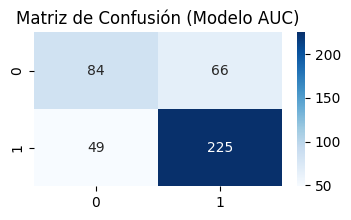



--- Resultados del Modelo Optimizado para MÁXIMO F1-MACRO ---

F1-macro Final en Test Set: 0.4735

Informe de Clasificación:
              precision    recall  f1-score   support

         1.0       0.50      0.35      0.41        34
         2.0       0.47      0.42      0.44       116
         3.0       0.65      0.76      0.70       233
         4.0       0.46      0.27      0.34        41

    accuracy                           0.58       424
   macro avg       0.52      0.45      0.47       424
weighted avg       0.57      0.58      0.57       424



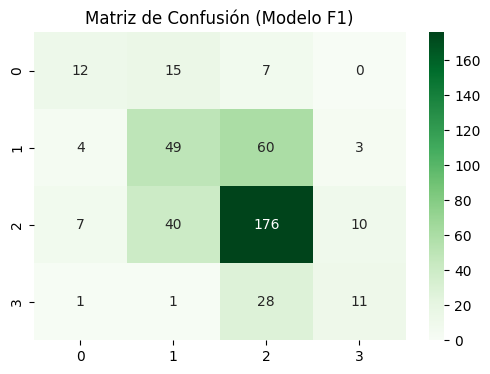



--- 📊 Importancia de Características (Modelo AUC) ---


<ipython-input-5-20127352>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plt.figure(figsize=(10, 8)); sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis'); plt.title('Top 20 Features (Modelo AUC)'); plt.show()


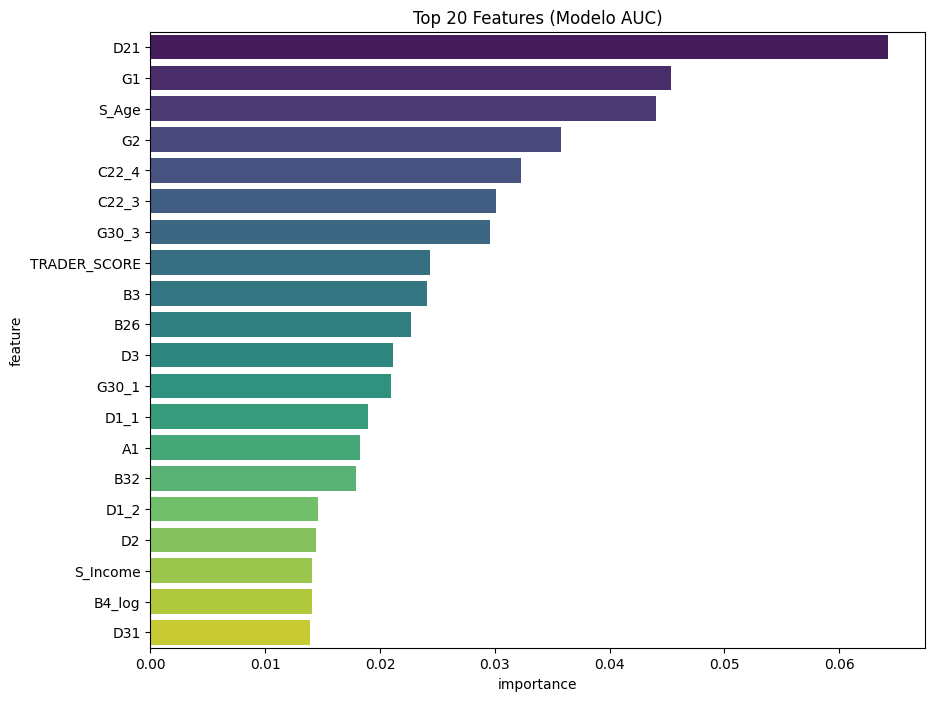

In [ ]:
# Evaluación Final y Análisis Visual de los Modelos Generalistas

# --- 1. Evaluación del Modelo Optimizado para AUC (2 Clases) ---
X_full_train = pd.concat([X_train, X_val], ignore_index=True)
y_full_train_2 = pd.concat([y_train[2], y_val[2]], ignore_index=True)
best_model_auc.fit(X_full_train, y_full_train_2)
y_pred_auc = best_model_auc.predict(X_test)
y_proba_auc = best_model_auc.predict_proba(X_test)[:, 1]

print("--- Resultados del Modelo Optimizado para MÁXIMO AUC ---")
print(f"\nAUC Final en Test Set: {roc_auc_score(y_test[2], y_proba_auc):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test[2], y_pred_auc))
cm_auc = confusion_matrix(y_test[2], y_pred_auc)
plt.figure(figsize=(4, 2)); sns.heatmap(cm_auc, annot=True, fmt='d', cmap='Blues'); plt.title('Matriz de Confusión (Modelo AUC)'); plt.show()


# --- 2. Evaluación del Modelo Optimizado para F1-macro (4 Clases) ---
y_full_train_4 = pd.concat([y_train[4], y_val[4]], ignore_index=True)
best_model_f1_4c.fit(X_full_train, y_full_train_4)
y_pred_f1 = best_model_f1_4c.predict(X_test)

print("\n\n--- Resultados del Modelo Optimizado para MÁXIMO F1-MACRO ---")
print(f"\nF1-macro Final en Test Set: {f1_score(y_test[4], y_pred_f1, average='macro'):.4f}")
print("\nInforme de Clasificación:")
print(classification_report(y_test[4], y_pred_f1, zero_division=0))
cm_f1 = confusion_matrix(y_test[4], y_pred_f1)
plt.figure(figsize=(6, 4)); sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Greens'); plt.title('Matriz de Confusión (Modelo F1)'); plt.show()

# --- 3. Análisis Visual de Importancia de Características (son del mismo dataset) ---
print("\n\n--- Importancia de Características (Modelo AUC) ---")
importances_auc = best_model_auc.named_steps['clf'].feature_importances_
feature_names = X_test.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances_auc}).sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(10, 8)); sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis'); plt.title('Top 20 Features (Modelo AUC)'); plt.show()

## 5. Guardado del modelo final para producción

Selecciona el modelo campeón (optimizado para AUC), define nombre y ruta de archivo, y guarda el pipeline entrenado en formato Joblib para su despliegue.


In [ ]:
# Guardado del Modelo Final para Producción

# --- 1. Seleccionar el modelo campeón y definir el nombre del archivo ---
# De nuestro análisis, el modelo optimizado para AUC (2 clases) es el más fiable
# y el objetivo de este notebook.
model_campeon = best_model_auc
model_filename = "modelo_riesgo_auc_v1.joblib" # Buena práctica: incluir propósito y versión.
model_path = FINAL_MODELS_DIR / model_filename

# --- 2. Guardar el pipeline del modelo ya entrenado ---
# El directorio FINAL_MODELS_DIR ya fue creado al importar config.py.
joblib.dump(model_campeon, model_path)

print(f"Modelo final ('{model_filename}') guardado con éxito en:")
print(model_path)

✅ Modelo final ('modelo_riesgo_auc_v1.joblib') guardado con éxito en:
/content/drive/MyDrive/Digitech/TFG/ML/Calculo-Riesgo/models/final/modelo_riesgo_auc_v1.joblib


## Conclusiones Finales
- El modelo binario (2 clases) demostró buena capacidad discriminativa (AUC ≈ 0.78 en test) y estabilidad entre CV y test, confirmando la robustez de la combinación SMOTE + Random Forest.  
- La clasificación multicategoría alcanzó un desempeño moderado (F1-macro ≈ 0.47), con alta eficacia en la categoría intermedia (clase 3) y menor rendimiento en extremos (clases 1 y 4), reflejando el impacto del desequilibrio y la superposición de características.  
- La curva de aprendizaje y la brecha entre CV y test fueron reducidas en ambos escenarios, lo que evidencia un buen control de overfitting tras la etapa focalizada de GridSearch.  
- El análisis de importancia de variables resaltó, entre las 20 principales, indicadores históricos de rendimiento y métricas de participación del estudiante como los drivers más decisivos para la predicción.  
- En conjunto, los resultados indican que, si bien es factible separar estudiantes en alto y bajo riesgo con alta fiabilidad, afinar la granularidad de cuatro niveles exige más datos o técnicas específicas para clases minoritarias.